## Set up data

In [1]:
import numpy as np
import pandas as pd

In [2]:
import stan

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
bpath = '~/source/rethinking/'

In [5]:
df = pd.read_csv(bpath + 'data/Howell1.csv', sep=';')

In [6]:
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Exercise 1

In [7]:
df_a = df[df['age'] >= 18].copy()

In [8]:
xbar = np.mean(df_a['weight'])

In [9]:
df_a['centred_weight'] = df_a['weight'] - xbar

In [10]:
model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0, upper=50> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
  alpha ~ normal(178, 20);
  beta ~ normal(0, 1);
}
"""

In [11]:
model_data = {"N": len(df_a),
                "x": df_a['weight'].to_numpy(),
                "y": df_a['height'].to_numpy()}


In [12]:
posterior = stan.build(model_code, data=model_data, random_seed=123)

Building...

Building: found in cache, done.Messages from stanc:
  The parameter sigma has no priors.
  Your Stan program has a parameter sigma with a lower and upper bound in its
  declaration. These hard constraints are not recommended, for two reasons:
  (a) Except when there are logical or physical constraints, it is very
  unusual for you to be sure that a parameter will fall inside a specified
  range, and (b) The infinite gradient induced by a hard constraint can cause
  difficulties for Stan's sampling algorithm. As a consequence, we recommend
  soft constraints rather than hard constraints; for example, instead of
  constraining an elasticity parameter to fall between 0, and 1, leave it
  unconstrained and give it a normal(0.5,0.5) prior distribution.
Warning at '/tmp/httpstan_y69zig2p/model_jxl2kd43.stan', line 14, column 17 to column 20:
  Argument 178 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).

In [13]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   3% (201/8000)
Sampling:   5% (401/8000)
Sampling:   9% (701/8000)
Sampling:  13% (1001/8000)
Sampling:  15% (1200/8000)
Sampling:  19% (1500/8000)
Sampling:  24% (1900/8000)
Sampling:  29% (2300/8000)
Sampling:  34% (2700/8000)
Sampling:  40% (3201/8000)
Sampling:  55% (4401/8000)
Sampling:  70% (5601/8000)
Sampling:  88% (7001/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000228 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000224 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000216 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.16 seconds.
  Adjust your expectations a

In [14]:
def predict_height(weight, pi):
    height_preds = fit['alpha'] + fit['beta'] * weight + np.random.normal(0, fit['sigma'])
    mean_height = np.mean(height_preds)
    height_interval = np.quantile(height_preds, [(1-pi)/2, 1-(1-pi)/2])

    return mean_height, height_interval[0], height_interval[1]

In [15]:
results = pd.DataFrame()

In [16]:
results['weight'] = [45, 40, 65, 31, 53]

In [17]:
results['expected'], results['lower'], results['upper'] = \
    zip(*results['weight'].map(lambda x: predict_height(x, 0.89)))

In [18]:
results

,weight,expected,lower,upper
0,45,154.500953,146.142718,162.600618
1,40,150.169650,142.028917,158.254779
2,65,172.254935,163.943952,180.587445
3,31,142.198274,133.944560,150.400114
4,53,161.764000,153.648749,169.976107


## Exercise 2

In [19]:
import math

In [20]:
df['log_weight'] = df['weight'].apply(math.log)

In [21]:
df['centred_log_weight'] = df['log_weight'] - np.mean(df['log_weight'])

In [22]:
model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0, upper=50> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
  alpha ~ normal(178, 20);
  beta ~ lognormal(0, 1);
}
"""

In [23]:
model_data = {"N": len(df),
                "x": df['centred_log_weight'].to_numpy(),
                "y": df['height'].to_numpy()}

In [24]:
posterior = stan.build(model_code, data=model_data, random_seed=321)

Building...

Building: found in cache, done.Messages from stanc:
  The parameter sigma has no priors.
  Your Stan program has a parameter sigma with a lower and upper bound in its
  declaration. These hard constraints are not recommended, for two reasons:
  (a) Except when there are logical or physical constraints, it is very
  unusual for you to be sure that a parameter will fall inside a specified
  range, and (b) The infinite gradient induced by a hard constraint can cause
  difficulties for Stan's sampling algorithm. As a consequence, we recommend
  soft constraints rather than hard constraints; for example, instead of
  constraining an elasticity parameter to fall between 0, and 1, leave it
  unconstrained and give it a normal(0.5,0.5) prior distribution.
Warning at '/tmp/httpstan_plbqzaij/model_53lpcodd.stan', line 14, column 17 to column 20:
  Argument 178 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).

In [25]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   5% (401/8000)
Sampling:  30% (2400/8000)
Sampling:  54% (4300/8000)
Sampling:  78% (6200/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.007355 seconds
  1000 transitions using 10 leapfrog steps per transition would take 73.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000146 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000136 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.36 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: Random variable is -0.0724811, but must be nonnegative! (i

In [26]:
preds = pd.DataFrame()

In [27]:
preds['seq_val'] = np.arange(1, 61, 1)

In [28]:
preds['log_seq_val'] = preds['seq_val'].apply(math.log)

In [29]:
preds['model_seq_val'] = preds['log_seq_val'] - np.mean(df['log_weight'])

In [30]:
preds['expected'], preds['lower'], preds['upper'] = \
    zip(*preds['model_seq_val'].map(lambda x: predict_height(x, 0.99)))

In [31]:
preds.tail()

,seq_val,log_seq_val,model_seq_val,expected,lower,upper
55,56,4.025352,0.583022,165.787257,152.743549,178.963978
56,57,4.043051,0.600721,166.521945,152.959914,180.010926
57,58,4.060443,0.618113,167.395459,153.751627,180.306507
58,59,4.077537,0.635208,168.193226,154.218111,182.045149
59,60,4.094345,0.652015,168.919761,155.553617,182.154251


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

(45.0, 185.0)

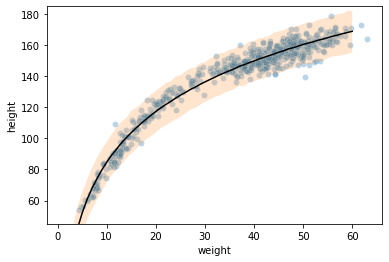

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(x=df['weight'],y=df['height'], ax=ax, alpha=0.3)
sns.lineplot(x=preds['seq_val'],y=preds['expected'], color = 'black')
ax.fill_between(preds['seq_val'], preds['lower'], preds['upper'], alpha=0.2)
plt.ylim(45, 185)